<div style="text-align: center; color:#FFF800">
    <h1><b>Assignment 2</b></h1>
    <h3>Artificial Intelligence - Spring 2024</h3></div>
<p style="text-align: center;text-decoration: underline">Alireza Hosseini</p>
<p style="text-align: center;text-decoration: underline">SID : 810100125</p>


In [1]:
import shutil
import os
import librosa
import numpy as np
import soundfile as sf
import random
import seaborn
import matplotlib.pyplot as plt
from tabulate import tabulate
import python_speech_features

speakers = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]
audioLength = 1200

def remove_silence_and_save(audio_file, destination):
    y, sr = librosa.load(audio_file)
    trimmed_audio, indices = librosa.effects.trim(y, top_db=45.0, frame_length=1024, hop_length=128)
    sf.write(destination, trimmed_audio, sr, format="wav")

#a Function to choose a bunch of files as tests and save them in tests' location 
def create_test_files(source_directory, num_of_tests, destination_directory):
    for i in range(10):
        choices = random.sample(os.listdir(os.path.join(source_directory, str(i))), num_of_tests)
        for choice in choices:
            shutil.copy(os.path.join(source_directory, str(i), choice), os.path.join(destination_directory, choice))
            os.remove(os.path.join(source_directory, str(i), choice))

#a Function to choose a bunch of files as tests and save them in tests' location 
def create_test_files_by_speakers(source_directory, num_of_tests, destination_directory):
    global speakers
    for name in speakers:
        choices = random.sample(os.listdir(os.path.join(source_directory, name)), num_of_tests)
        for choice in choices:
            shutil.copy(os.path.join(source_directory, name, choice), os.path.join(destination_directory, choice))
            os.remove(os.path.join(source_directory, str(name), choice))

#a Function to clear files in a folder
def clear_folder(folder_path):
    for file in os.listdir(folder_path):
        os.remove(os.path.join(folder_path, file))

#a Function to calculate Confusion Matrix
def cal_confusion_matrix(results):
    mat = [[0] * 10 for _ in range(10)]
    for res in results :
        prediction, real = res
        for i in range(10):
            if(i == int(real)):
                for j in range(10):
                    if(j == int(prediction)):
                        mat[i][j] += 1
    return mat

#a Function to calculate accuracy
def cal_accuracy(results):
    temp = 0
    for prediction,real in results :
        if prediction == int(real):
            temp += 1
    return temp/len(results)

#a Function to calculate metrics needed
def cal_metrics(results):
    tempData = dict()
    for digit in range(10):
        truePos = 0
        falsePos = 0
        falseNeg = 0
        for res in results :
            prediction, real = res
            if (prediction == digit and int(real) == prediction):
                truePos += 1
            elif (prediction == digit and int(real) != prediction):
                falsePos += 1
            elif (int(real) == digit and int(real) != prediction):
                falseNeg += 1
        tempData[digit] = (truePos, falsePos, falseNeg)

    metrics = [[] for _ in range(10)]
    for digit in range(10):
        metrics[digit] = []
        truePos, falsePos, falseNeg = tempData[digit]
        metrics[digit].append(digit) #Digit itself (for furthur use in tables)
        metrics[digit].append(truePos / (truePos + falsePos)) #Precision
        metrics[digit].append(truePos / (truePos + falseNeg)) #Recall
        metrics[digit].append(2 * (metrics[digit][2] * metrics[digit][1]) /
                               (metrics[digit][2]+metrics[digit][1])) #F1
        
    return metrics

#a Function to calculate Accuract, Precision, Recall, F1 Score and Plot Confusion Matrix
def show_evaluation(hmm_models, mode, test_directory):
    global audioLength
    prediction_results =[]
    for file in os.listdir(test_directory):
        scores = []
        signal, sampleRate = librosa.load(os.path.join(test_directory, file))
        mfcc_features = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
        for idx, model in hmm_models.items() :
            if(mode == "library") :
                scores.append(model.score(mfcc_features))
            else :
                scores.append(model.score(mfcc_features.T/np.amax(mfcc_features.T)))
        bestScoreIdx = np.array(scores).argmax()
        prediction_results.append((bestScoreIdx, file[0])) #save a tuple consisting of model's prediction and actual value


    confusion_matrix = cal_confusion_matrix(prediction_results)
    accuracy = cal_accuracy(prediction_results)
    metrics = cal_metrics(prediction_results)


    plt.figure(figsize=(8, 6))
    seaborn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=list(range(10)), yticklabels=list(range(10)))
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    print(tabulate(metrics, ["Precision","Recall","F1"], tablefmt='fancy_grid'))
    print(f"Total Accuracy: {accuracy*100:.3f}%")


#a Function to calculate Confusion Matrix for Speakers
def cal_speaker_confusion_matrix(results):
    global speakers
    mat = [[0] * len(speakers) for _ in range(len(speakers))]
    for prediction,real in results :
        for i in range(len(speakers)):
            if(speakers[i] == (real)):
                for j in range(len(speakers)):
                    if(speakers[j] == prediction):
                        mat[i][j] += 1
    return mat

#a Function to calculate model accuracy for Speakers
def cal_speaker_accuracy(results):
    temp = 0
    for prediction,real in results :
        if prediction == real:
            temp += 1
    return temp/len(results)

#a Function to calculate important metrics for Speakers
def cal_speaker_metrics(results):
    global speakers
    tempData = dict()
    for name in speakers:
        truePos = 0
        falsePos = 0
        falseNeg = 0
        for prediction,real in results :
            if (prediction == name and real == prediction):
                truePos += 1
            elif (prediction == name and real != prediction):
                falsePos += 1
            elif (real == name and real != prediction):
                falseNeg += 1
        tempData[name] = (truePos, falsePos, falseNeg)

    metrics = [[] for _ in range(len(speakers))]
    for i in range(len(speakers)):
        metrics[i] = []
        truePos, falsePos, falseNeg = tempData[speakers[i]]
        metrics[i].append(speakers[i]) #Digit itself (for furthur use in tables)
        metrics[i].append(truePos / (truePos + falsePos)) #Precision
        metrics[i].append(truePos / (truePos + falseNeg)) #Recall
        metrics[i].append(2 * (metrics[i][2] * metrics[i][1]) /
                               (metrics[i][2]+metrics[i][1])) #F1
        
    return metrics

#a Function to calculate Accuract, Precision, Recall, F1 Score and Plot Confusion Matrix for Speakers
def show_speakerEvaluation(hmm_models, mode, test_directory):
    global audioLength, speakers
    prediction_results =[]
    for file in os.listdir(test_directory):
        scores = []
        names = []
        file_name = file.split("_")
        signal, sampleRate = librosa.load(os.path.join(test_directory, file))
        mfcc_features = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
        for name, model in hmm_models.items() :
            if(mode == "library") :
                scores.append(model.score(mfcc_features))
            else :
                scores.append(model.score(mfcc_features.T/np.amax(mfcc_features.T)))
            names.append(name)
        bestScoreIdx = np.array(scores).argmax()
        prediction_results.append((names[bestScoreIdx], file_name[1])) #save a tuple consisting of model's prediction and actual value


    confusion_matrix = cal_speaker_confusion_matrix(prediction_results)
    accuracy = cal_speaker_accuracy(prediction_results)
    metrics = cal_speaker_metrics(prediction_results)


    plt.figure(figsize=(8, 6))
    seaborn.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=speakers, yticklabels=speakers)
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')

    print(tabulate(metrics, speakers, tablefmt='fancy_grid'))
    print(f"Total Accuracy: {accuracy*100:.3f}%")

    


<h3><strong>Questions : </strong><h3>
<img src="./Questions/Q1.png" style="text-align: right"/>

Segmentation refers to process of dividing a dataset into smaller, more managable subsets based on certain characteristics. In case of our practice (audio processing) segmentation can help with extraction of features in the next steps and classification of smaller segments

In [43]:
#Seperating file and Preprocessing (Removing silent parts of audio files) for Visualisation
source_dir = "/home/alireza/University/AI/assignments/A2/recordings"
destination_dir = "/home/alireza/University/AI/assignments/A2/dataset"

for audio in os.listdir(source_dir):
    if(not os.path.exists(os.path.join(destination_dir, audio[0]))):
        os.makedirs(os.path.join(destination_dir, audio[0]))
    
    remove_silence_and_save(os.path.join(source_dir, audio), os.path.join(destination_dir, audio[0], audio))
    #shutil.copy(os.path.join(source_dir, audio), os.path.join(destination_dir, audio[0]))

print("Segmentation and Preprocessing Complete!")

Segmentation and Preprocessing Complete!


In [60]:
#Stats and Visualization of Model (made with Library)
clear_folder("/home/alireza/University/AI/assignments/A2/autoTests")
create_test_files(destination_dir, 50, "/home/alireza/University/AI/assignments/A2/autoTests")

<img src="./Questions/Q2.png"/>

1. <div><b>Zero Crossing Rate : </b> refers to the rate at which the audio waveform changes its sign (crosses horizontal axis withing a given timeframe), often used to estimate characteristics of signal such as pitch or periodicity (ex. speech signals tend to have higher zero crossing rates) </div>
2. <div><b>Mel-Spectrogram : </b> A mel spectrogram is a variation of the spectrogram that is commonly used in speech processing task. It is similar to a spectrogram (in that it shows the frequency content of an audio signal over time) but on a different frequency axis as it converts the frequencies to the Mel Scale. The Mel scale is designed to mimic  the human auditory system's response to different frequencies. (It's nonlinear and emphesizes lower frequencies more that higher ones)</div>
3. <div><b>Chroma Features :</b> Chroma features represent the distribution of energy in the audio signal across different pitch classes (or notes), typically within the twelve-tone equal temperament scale used in Western music. Instead of representing the entire spectrum of frequencies like spectrograms, our focus is mainly on the relative presence or absence of pitch classes (or notes) in the audio signal. (useful for tasks such as music genre classification)</div>
4. <div><b>Mel-Frequency Cepstral Coefficients (MFCC) :</b> Derived from the Mel-Spectrogram by taking the logarithm of the power spectrum, followed by the discrete cosine transform (DCT), resulting in a set of coefficients representing a shallow copy of the original audio with it's most important characteristics but with less depth and details.</div>

Audio number : 0


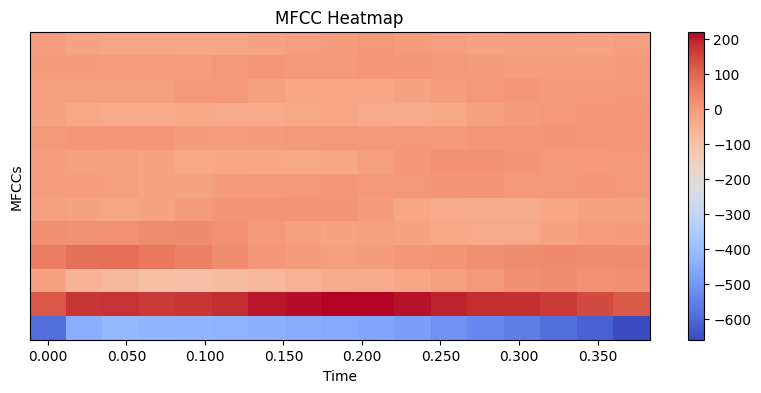

Audio number : 1


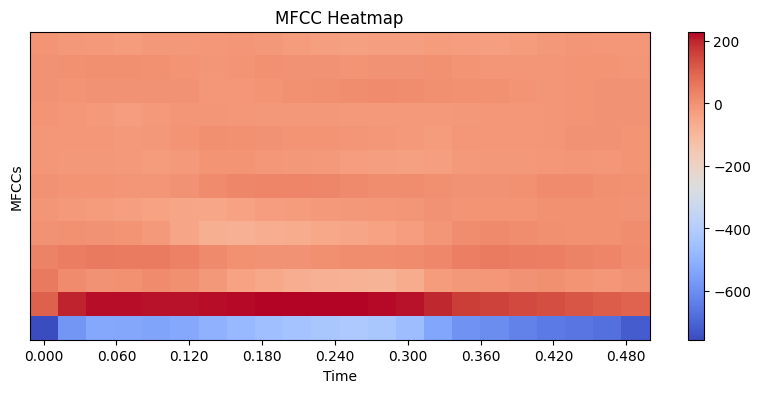

Audio number : 2


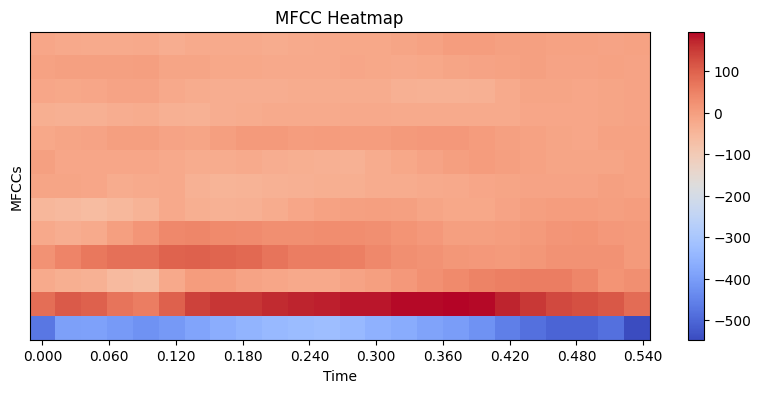

Audio number : 3


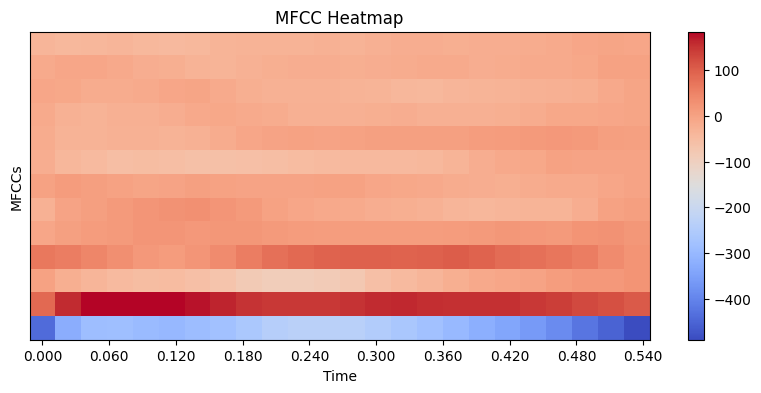

Audio number : 4


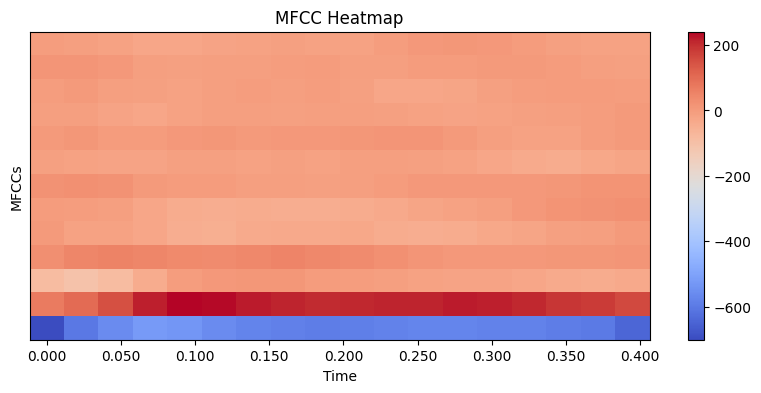

Audio number : 5


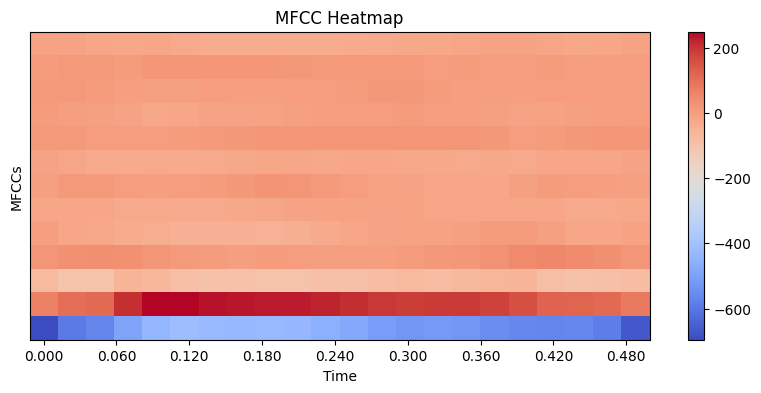

Audio number : 6


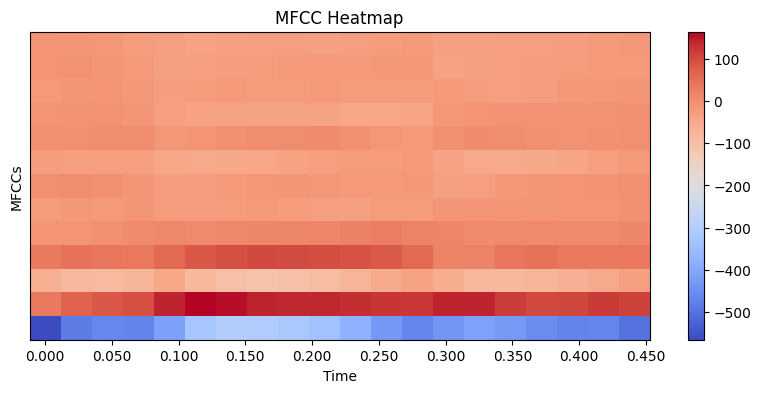

Audio number : 7


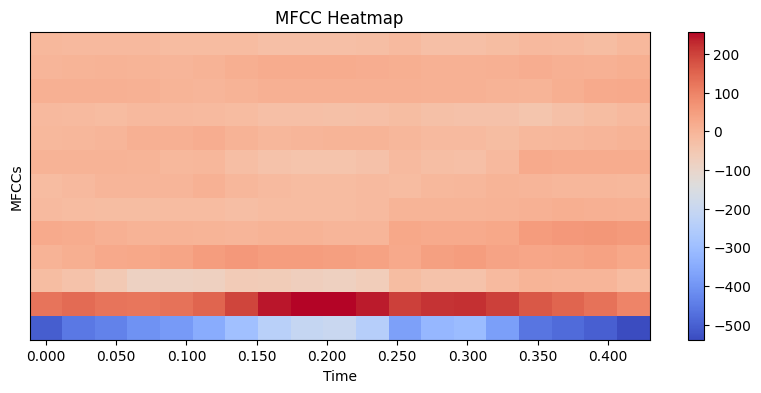

Audio number : 8


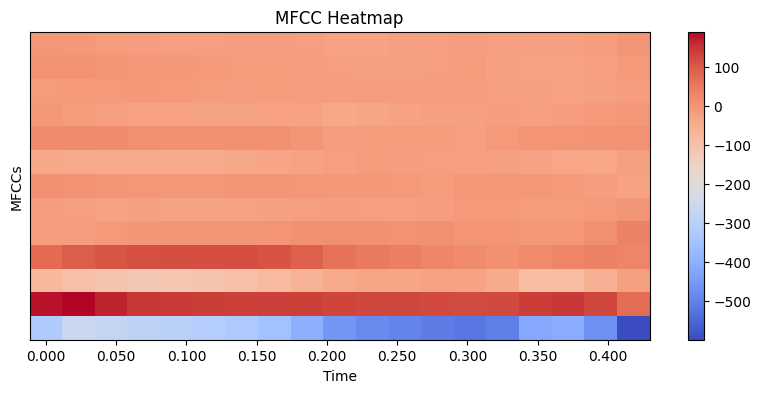

Audio number : 9


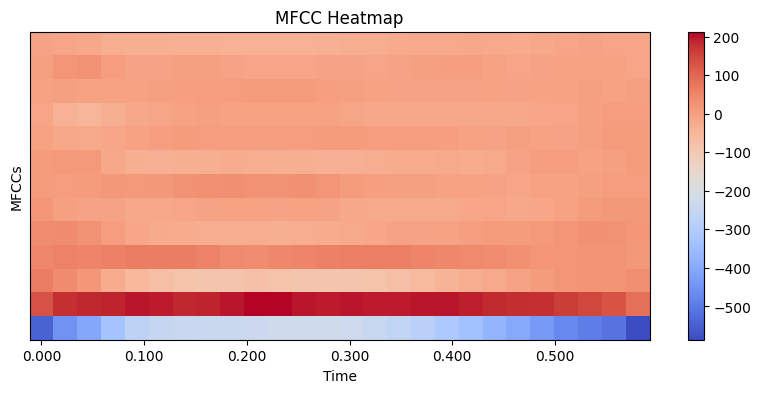

In [5]:
#MFCCs Visualisation
import random as rd
import matplotlib.pyplot as plt


for i in range(10):
    files = os.listdir(os.path.join(destination_dir, str(i)))
    tracks = [file for file in files]
    chosen_track = rd.choice(tracks)
    signal, sampleRate = librosa.load(os.path.join(destination_dir, str(i), chosen_track))
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13, sr=sampleRate)
    print(f"Audio number : {i}")
    plt.figure(figsize=(10,4))
    librosa.display.specshow(mfccs, x_axis="time", sr=sampleRate)
    plt.ylabel("MFCCs")
    plt.title("MFCC Heatmap")
    plt.colorbar()
    plt.show()


<img src="./Questions/Q3.png"/>

3. <div>Robustness of MFCCs refers to the ability of MFCCs to capture and represent important characteristics of the audio signal consistently across different variations, such as changes in speaker, background noise and recording conditions. MFCCs are robust to changes in speaker identity and environmental conditions, as well as certain type of background noises and channel effects.</div>
4. <div> Not useful for non-acoustic signals (such as biomedical or environmental sounds), High Computational cost, MFCC is sensitive to background noise</div>
5. <div>overlapping frames, we ensure that each frame contains information not only about its immediate time window but also about the surrounding context. It also to smooth out abrupt changes in the spectral content of the audio signal between adjacent frames. </div>
6. <div> Usually gives more relevant information about spectral envelope of the audio signal. It also brings computational efficiency as well as more robustness to noise (as lower coefficients get less affected by background noise) It's also a historical observation that these coefficients tend to be better and easier to use.</div>


<img src="./Questions/Q4.png"/>

<div><b>States</b> are hidden underlying conditions that generate the audio we can hear, <b>Observations</b> are features such as signal power that we can measure/extract from the audio file.</div>
In this project <b>States</b> can be Numbers (said in audio files) or Phonemes, <b>Observations</b> are MFCCs that we have calculated so far.

<img src="./Questions/Q5.png"/>

A First-Order HMM is named as such because the model assumes the Markov property of first order which means next state depends only on the current state and not any state prior.
Features of First-Order HMM : 
- __Limited Memory (Markov Property) :__ Probability of being in a particular state at a given time step depends only on the previous state, not on the entire history of states. (which makes the model computationally efficient)
- __Discrete Time Steps: :__ Observations and State Transitions are assumed to happen at specific intervals
- __Simplicity :__ First-Order HMMs are relatively simpler and computationaly less complex (than other kinds of HMMs) making them efficient for a broad number of applications
- __Stationary Transitions :__ The transition probability matrix is assumend constant over time.

<img src="./Questions/Q6.png"/>

- __Speech Recognition :__ he hidden states of a speaker's vocal tract (e.g., phonemes) that create observable sounds. 
- __Bioinformatics - Gene Prediction :__ HMMs can model the hidden states of genetic coding regions (e.g., exons, introns) that emit observable nucleotides (A, C, G, T).
- __Part-of-Speech Tagging :__ HMMs can model the hidden states of grammatical parts-of-speech that create observable words. Transition can model things like noun followed by verb.
- Other Applications : 
    - Handwriting Recognition
    - Gesture Recognition
    - Machine Translation
> HMMs provide a probabilistic framework allowing for uncertainty modeling. They are relatively simple and efficient in comparison to other ways of modeling systems.

<img src="./Questions/Q7.png"/>

- ```Advantages :```
    - __Effective for sequential data :__ HMMs shines at handling data where observations occur in a sequence and are influenced by underlying hidden states. This makes them suitable for tasks like speech recognition, where there are sequence of sounds, or gene prediction in DNA sequences.
    - __Simple and Efficient :__ Compared to more complex models like Neural Networks, HMMs are easier to train and computationally efficient making them suitable for real-time applications.
    - __Probabilistic framework :__ HMMS allow for incorporating uncertainty into models and estimating the likelihood of different hidden state sequences explaining the observed data.
    - __Strong theoretical foundation :__ HMMs have a long-standing mathematical foundation, which makes them a lot more reliable.
----------------
- ```Disdvantages :```
    - __Limited memory (Markov property) :__ HMMs assume the probability of being in a particular state depends only on the previous state, not the entire history. This can be a disadvantage for tasks where long-range dependencies matter.
    - __Fixed number of hidden states :__ Since the number of hidden states in an HMM is predefined, choosing an inappropriate number of states can impact the model's performance.
    - __Local Optimum :__ The training algorithms for HMMs can get stuck in local optima, making the choice of initial parameters crucial.

<img src="./Questions/Q8.png"/>

1. __Left-Right HMM :__  The hidden states can only transition forward in a sequence. This means the model can't jump back to previous states.
2. __Ergodic HMM :__ Allow transitions between any hidden state at any time step, results in more flexibility but can also cause complexity.
3. __Hidden Semi-Markov Models (HSMM) :__ Extends the first-order HMM by allowing variable durations for each hidden state. Useful for modeling sequences where the time spent in each state is not constant.
4. __Coupled HMMs :__ Involves multiple HMMs working together. Each HMM might model a different datasets and the hidden states of one HMM can influence the transitions in __another__. 
5. __Factorial HMMs :__ These models decompose the hidden states into multiple factors, each representing a different aspect of the underlying process. Allows for more complex hidden states.
6. __Hierarchical HMMs :__ This type involves a hierarchy of HMMs, where higher-level models control the behavior of lower-level ones. This allows modeling nested hidden states.

<h3 style=color:#FF0013> <strong>Implementation with Libraries</strong> </h3>

In [55]:
#Preprocessing

source_dir = "/home/alireza/University/AI/assignments/A2/recordings"
destination_dir = "/home/alireza/University/AI/assignments/A2/dataset"

for audio in os.listdir(source_dir):
    if(not os.path.exists(os.path.join(destination_dir, audio[0]))):
        os.makedirs(os.path.join(destination_dir, audio[0]))
    
    remove_silence_and_save(os.path.join(source_dir, audio), os.path.join(destination_dir, audio[0], audio))
    #shutil.copy(os.path.join(source_dir, audio), os.path.join(destination_dir, audio[0]))

print("Segmentation and Preprocessing Complete!")

Segmentation and Preprocessing Complete!


In [57]:
from hmmlearn.hmm import GaussianHMM
import python_speech_features
import numpy as np

# Define number of hidden states for each number HMM 
n_states = 6
audioLength = 1200

# Create dictionary to store number HMMs
HMM_models = {}

for num in range(10):  # 0-9
  
  # Initialize a GaussianHMM instance
  HMM_models[num] = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=18)


# Training data (Extracting features)
num_features = {}  # MFCC features for each number

for i in range(10):
    X = np.array([])
    files = os.listdir(os.path.join(destination_dir, str(i)))
    tracks = [file for file in files]
    for track in tracks :
      signal, sampleRate = librosa.load(os.path.join(destination_dir, str(i), track))
      mfccs = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
      if(len(X) == 0):
        X = mfccs
      else :
        X = np.append(X, mfccs, axis=0)
    num_features[i] = X
        
      


# Train each HMM using features of corresponding number data
for num, features in num_features.items():
     HMM_models[num].fit(features)
  
print("Model Training Complete!")


Model Training Complete!


In [58]:
#Test Trained Models
test_dir = "/home/alireza/University/AI/assignments/A2/autoTests"

for file in os.listdir(test_dir):
    scores = []
    signal, sampleRate = librosa.load(os.path.join(test_dir, file))
    mfcc_features = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
    for idx, model in HMM_models.items() :
        x = model.score(mfcc_features)
        scores.append(x)
    bestScoreIdx = np.array(scores).argmax()
    print(f"Original File : {file} \n Predicted Number : {bestScoreIdx}")

Original File : 4_jackson_27.wav 
 Predicted Number : 4
Original File : 3_yweweler_23.wav 
 Predicted Number : 3
Original File : 0_jackson_42.wav 
 Predicted Number : 0
Original File : 0_theo_30.wav 
 Predicted Number : 0
Original File : 4_jackson_3.wav 
 Predicted Number : 4
Original File : 4_yweweler_13.wav 
 Predicted Number : 4
Original File : 6_lucas_48.wav 
 Predicted Number : 6
Original File : 5_nicolas_14.wav 
 Predicted Number : 5
Original File : 0_yweweler_11.wav 
 Predicted Number : 0
Original File : 9_nicolas_16.wav 
 Predicted Number : 9
Original File : 0_nicolas_1.wav 
 Predicted Number : 0
Original File : 7_nicolas_49.wav 
 Predicted Number : 7
Original File : 4_george_46.wav 
 Predicted Number : 4
Original File : 4_jackson_48.wav 
 Predicted Number : 4
Original File : 9_george_34.wav 
 Predicted Number : 9
Original File : 8_jackson_40.wav 
 Predicted Number : 8
Original File : 9_theo_19.wav 
 Predicted Number : 9
Original File : 7_jackson_13.wav 
 Predicted Number : 7
O

╒════╤═════════════╤══════════╤══════════╕
│    │   Precision │   Recall │       F1 │
╞════╪═════════════╪══════════╪══════════╡
│  0 │    0.921569 │     0.94 │ 0.930693 │
├────┼─────────────┼──────────┼──────────┤
│  1 │    0.925926 │     1    │ 0.961538 │
├────┼─────────────┼──────────┼──────────┤
│  2 │    0.888889 │     0.96 │ 0.923077 │
├────┼─────────────┼──────────┼──────────┤
│  3 │    0.934783 │     0.86 │ 0.895833 │
├────┼─────────────┼──────────┼──────────┤
│  4 │    1        │     0.98 │ 0.989899 │
├────┼─────────────┼──────────┼──────────┤
│  5 │    1        │     0.88 │ 0.93617  │
├────┼─────────────┼──────────┼──────────┤
│  6 │    0.96     │     0.96 │ 0.96     │
├────┼─────────────┼──────────┼──────────┤
│  7 │    0.979592 │     0.96 │ 0.969697 │
├────┼─────────────┼──────────┼──────────┤
│  8 │    0.961538 │     1    │ 0.980392 │
├────┼─────────────┼──────────┼──────────┤
│  9 │    0.941176 │     0.96 │ 0.950495 │
╘════╧═════════════╧══════════╧══════════╛
Total Accur

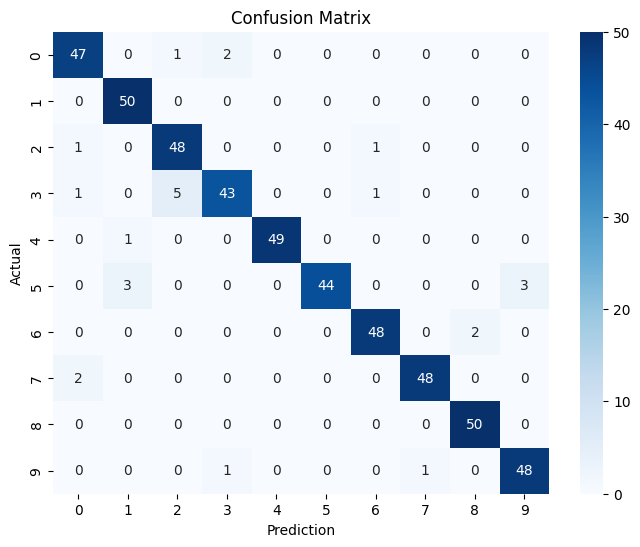

In [61]:
#Stats and Visualization of Model (made with Library)
show_evaluation(HMM_models, mode="library", test_directory="/home/alireza/University/AI/assignments/A2/autoTests")

<h3 style=color:#FF0013> <strong>Implementation from Scratch</strong> </h3>

In [9]:
from scipy.stats import multivariate_normal
import numpy as np

class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:,0] = self.initial_prob[:,0] * observation_matrix[:,0]
            else:
                alpha[:,t] = np.matmul(self.transition_matrix.T, alpha[:,t-1]) * observation_matrix[:,t]

            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T,mean =self.mean[:,s],cov = self.covariances[:,:,s])

        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:, 0],(-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum,axis=(0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood


In [10]:
#Preprocessing

source_dir = "/home/alireza/University/AI/assignments/A2/recordings"
destination_dir = "/home/alireza/University/AI/assignments/A2/dataset"

for audio in os.listdir(source_dir):
    if(not os.path.exists(os.path.join(destination_dir, audio[0]))):
        os.makedirs(os.path.join(destination_dir, audio[0]))
    
    remove_silence_and_save(os.path.join(source_dir, audio), os.path.join(destination_dir, audio[0], audio))
    #shutil.copy(os.path.join(source_dir, audio), os.path.join(destination_dir, audio[0]))

print("Segmentation and Preprocessing Complete!")

Segmentation and Preprocessing Complete!


In [11]:
import python_speech_features

# Create dictionary to store number HMMs
custom_HMM_models = {}

# Define number of hidden states for each number HMM 
n_states = 5
audioLength = 600


for num in range(10):  # 0-9
  
  # Initialize a GaussianHMM instance
  custom_HMM_models[num] = HMM(num_hidden_states=n_states)


# Training data (Extracting features)
num_features = {}  # MFCC features for each number

for i in range(10):
    X = np.array([])
    files = os.listdir(os.path.join(destination_dir, str(i)))
    tracks = [file for file in files]
    for track in tracks :
      signal, sampleRate = librosa.load(os.path.join(destination_dir, str(i), track))
      mfccs = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
      if(len(X) == 0):
        X = mfccs
      else :
        X = np.append(X, mfccs, axis=0)
    num_features[i] = X
        
      


# Train each HMM using features of corresponding number data
for num, features in num_features.items():
     custom_HMM_models[num].train(features.T/np.amax(features.T), 9)
  
print("Model Training Complete!")


Model Training Complete!


In [24]:
test_dir = "/home/alireza/University/AI/assignments/A2/autoTests"

for file in os.listdir(test_dir):
    scores = []
    signal, sampleRate = librosa.load(os.path.join(test_dir, file))
    mfcc_features = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
    for idx, model in custom_HMM_models.items() :
        x = model.score(mfcc_features.T/np.amax(mfcc_features.T))
        scores.append(x)
    bestScoreIdx = np.array(scores).argmax()
    print(f"Original File : {file} \n Predicted Number : {bestScoreIdx}")

Original File : 4_jackson_3.wav 
 Predicted Number : 4
Original File : 4_lucas_17.wav 
 Predicted Number : 4
Original File : 7_jackson_40.wav 
 Predicted Number : 7
Original File : 6_nicolas_47.wav 
 Predicted Number : 6
Original File : 6_george_23.wav 
 Predicted Number : 6
Original File : 3_nicolas_10.wav 
 Predicted Number : 6
Original File : 7_theo_49.wav 
 Predicted Number : 6
Original File : 5_george_25.wav 
 Predicted Number : 5
Original File : 4_jackson_48.wav 
 Predicted Number : 4
Original File : 3_george_13.wav 
 Predicted Number : 6
Original File : 0_george_23.wav 
 Predicted Number : 3
Original File : 5_jackson_44.wav 
 Predicted Number : 5
Original File : 2_yweweler_19.wav 
 Predicted Number : 2
Original File : 8_yweweler_33.wav 
 Predicted Number : 8
Original File : 4_theo_45.wav 
 Predicted Number : 1
Original File : 3_yweweler_11.wav 
 Predicted Number : 6
Original File : 6_nicolas_4.wav 
 Predicted Number : 6
Original File : 4_george_43.wav 
 Predicted Number : 5
Orig

╒════╤═════════════╤══════════╤══════════╕
│    │   Precision │   Recall │       F1 │
╞════╪═════════════╪══════════╪══════════╡
│  0 │    1        │     0.22 │ 0.360656 │
├────┼─────────────┼──────────┼──────────┤
│  1 │    0.44898  │     0.88 │ 0.594595 │
├────┼─────────────┼──────────┼──────────┤
│  2 │    0.68     │     0.68 │ 0.68     │
├────┼─────────────┼──────────┼──────────┤
│  3 │    0.595745 │     0.56 │ 0.57732  │
├────┼─────────────┼──────────┼──────────┤
│  4 │    1        │     0.36 │ 0.529412 │
├────┼─────────────┼──────────┼──────────┤
│  5 │    0.586667 │     0.88 │ 0.704    │
├────┼─────────────┼──────────┼──────────┤
│  6 │    0.492754 │     0.68 │ 0.571429 │
├────┼─────────────┼──────────┼──────────┤
│  7 │    0.75     │     0.6  │ 0.666667 │
├────┼─────────────┼──────────┼──────────┤
│  8 │    0.714286 │     0.8  │ 0.754717 │
├────┼─────────────┼──────────┼──────────┤
│  9 │    0.833333 │     0.6  │ 0.697674 │
╘════╧═════════════╧══════════╧══════════╛
Total Accur

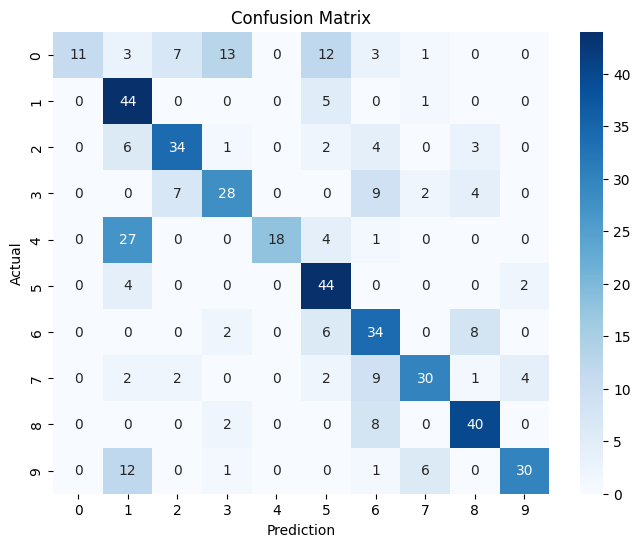

In [48]:

show_evaluation(custom_HMM_models, mode="non-library", test_directory="/home/alireza/University/AI/assignments/A2//autoTests")


### ```Library vs. CustomHMM```
- __Key Points__ :
    - Library implementation had overal better performance (as expected)
    - __Library__ had better performance when no part of the audio files were removed BUT __CustomHMM__ performed better when the silent parts of the audio files were removed
    - Library had more problems (relatively) in Precision but Custom HMM had more problems (relatively) in Recall
    - __Both__ had trouble in detecting number 3! (might point to the fact that audio files of digit 3 had lower quality)
- __It's obvious that Libraries use the most efficient algorithms and Classes available and what we build from scratch can reach as much, so the difference between performance of the Models shown above are totally expected__

<h2 style=color:#63B8FF><b>Evaluation and Analysis</b></h2>

<img src="./Questions/Q9.png"/>

1. <div><b>Accuracy : </b> Overal correctness of the Model, It's simply ratio of correctly classified tests to the total number of tests </div>
$$\ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Number of Predictions}} $$
2. <div><b>Precision : </b> Proportion of positive predictions that were actually correct, Tells us How often is Model right when it says something is positive, In context of our Models a False Positive is when an audio track is classified as digit "A" when It's actually not! </div>
$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Positives}} $$
3. <div><b>Recall : </b> Proportion of actual positive cases that were correctly identified by the model, Tells us how good is the Model at finding all the positive samples. In context of our Models a False Negative happens when a Model classifies audio of digit "A" as digit "B" <b>(False Negative for Model A and a False Positive for Model B)</b> </div>
$$ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives + False Negatives}} $$
4. <div><b>F1 : </b> Harmonic mean between Precision and Recall, combining them in a single metric to represent the Model </div>
$$ \text{F1 score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}} $$

<img src="./Questions/Q10.png"/>

<div><b>Class Distribution : </b> In real-world Data-sets classes often do not have an even numnber of samples for each class, thi can lead to misleading statistics. To solve this problem I have used Test samples that have even number of test for each digit. </div>
<div><b>Limitation of Data :</b> For minority classes with limited data, It can be hard to calculate desired metrics and You can't make conclusion based of those results. To solve this I made sure that there are enough cases for each Model to have sufficient data to calculate metrics.</div>

<img src="./Questions/Q11.png"/>

1. <div><b>Accuracy : </b> Higher accuracy is ideal but It can be misleading! Suppose we have a spam filter that classifies 99% of emails correctly, but only 1% of emails are actually spam, a Model that detects every email as non-spam would achieve the same accuracy! </div>-
2. <div><b>Precision : </b> Higher precision means a Model makes less mistakes when classifying something as positive (lower False Positive) This is important in medical cases where a single false positive can cause unnecessary procedures. </div>-
3. <div><b>Recall : </b> A High recall indicates the Model finds most of positive cases (eventhough it might have false positives) It can be important in a lie detector system, detecting truth as lie wont hurt as much as passing a lie undetected. </div>-
4. <div><b>F1 : </b> Higher F1 scores means the Model does good in terms of both Precision AND Recall, it's a better choice when you care about both finding most of the positive cases (high recall) and making sure the positive predictions are accurate (high precision). </div>-

<img src="./Questions/Q12.png"/>

##### Precision:

- __Focuses on:__ Identifying how many of the model's positive predictions are actually correct.
Calculation: Precision = (True Positives) / (True Positives + False Positives)
Interpretation: A high precision indicates that the model is mostly accurate when predicting the positive class. It reduces the number of false positives.
##### Recall:

 - __Focuses on:__ Identifying how many of the actual positive cases are correctly predicted by the model.
Calculation: Recall = (True Positives) / (True Positives + False Negatives)
Interpretation: A high recall indicates that the model is able to capture most of the relevant positive cases. It reduces the number of false negatives.

##### Spam Filtering :
- __High Precision:__ The model rarely classifies non-spam emails as spam (low false positive rate) but The model misses a significant number of actual spam emails (high false negative rate -> low recall). This means many spam emails end up in the inbox (poor overall performance).
- __High Recall:__ The model flags every single email it receives as spam. This approach would have very high recall as it would catch all spam emails (minimizing False Negatives) But it would also flag a massive amount of normal emails as spam (low precision).

<img src="./Questions/Q13.png"/>

- __F1__ uses __harmonic mean__ instead of __arithmetic mean__. In arithmetic mean higher values have more wieght but in harmonic mean influence of all the values are balanced even the very low ones.
- In our case It's important so that a Model with __only high Precision__ or __only high Recall__ cant achieve a High F1 Score and instead we have a balanced view of our model's performance.

<img src="./Questions/Q14.png"/>

#### __Done already in the previous Cells, needed stats are shown beloew each Cell__

<img src="./Questions/Q15.png"/>

<h3 style=color:#FF0013> <strong>Using hmmlearn Library</strong> </h3>

In [30]:
#Preprocessing

source_dir = "/home/alireza/University/AI/assignments/A2/recordings"
destination_dir = "/home/alireza/University/AI/assignments/A2/datasetBySpeaker"

for audio in os.listdir(source_dir):
    file_name = audio.split("_")
    if(not os.path.exists(os.path.join(destination_dir, file_name[1]))):
        os.makedirs(os.path.join(destination_dir, file_name[1]))
    
    remove_silence_and_save(os.path.join(source_dir, audio), os.path.join(destination_dir, file_name[1], audio))
    #shutil.copy(os.path.join(source_dir, audio), os.path.join(destination_dir, file_name[1]))

print("Segmentation and Preprocessing Complete!")

Segmentation and Preprocessing Complete!


In [38]:
clear_folder("/home/alireza/University/AI/assignments/A2/autoTests")
create_test_files_by_speakers(destination_dir, 50, "/home/alireza/University/AI/assignments/A2/autoTests")

In [34]:
from hmmlearn.hmm import GaussianHMM
import python_speech_features
import numpy as np

speakers = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]

# Define number of hidden states for each number HMM 
n_states = 6
audioLength = 1200

# Create dictionary to store number HMMs
speakerDetection_models = {}

for name in speakers:  
  
  # Initialize a GaussianHMM instance
  speakerDetection_models[name] = GaussianHMM(n_components=n_states, covariance_type='diag', n_iter=12)


# Training data (Extracting features)
speaker_features = {}  # MFCC features for each speaker

for name in speakers:
    X = np.array([])
    files = os.listdir(os.path.join(destination_dir, name))
    tracks = [file for file in files]
    for track in tracks :
      signal, sampleRate = librosa.load(os.path.join(destination_dir, name, track))
      mfccs = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
      if(len(X) == 0):
        X = mfccs
      else :
        X = np.append(X, mfccs, axis=0)
    speaker_features[name] = X
        
      


# Train each HMM using features of corresponding number data
for name, features in speaker_features.items():
     speakerDetection_models[name].fit(features)
  
print("Model Training Complete!")

Model Training Complete!


╒══════════╤═══════════╤═════════╤═══════════╕
│ george   │   jackson │   lucas │   nicolas │
╞══════════╪═══════════╪═════════╪═══════════╡
│ george   │  1        │    1    │  1        │
├──────────┼───────────┼─────────┼───────────┤
│ jackson  │  0.943396 │    1    │  0.970874 │
├──────────┼───────────┼─────────┼───────────┤
│ lucas    │  1        │    1    │  1        │
├──────────┼───────────┼─────────┼───────────┤
│ nicolas  │  1        │    1    │  1        │
├──────────┼───────────┼─────────┼───────────┤
│ theo     │  1        │    0.84 │  0.913043 │
├──────────┼───────────┼─────────┼───────────┤
│ yweweler │  0.890909 │    0.98 │  0.933333 │
╘══════════╧═══════════╧═════════╧═══════════╛
Total Accuracy: 97.000%


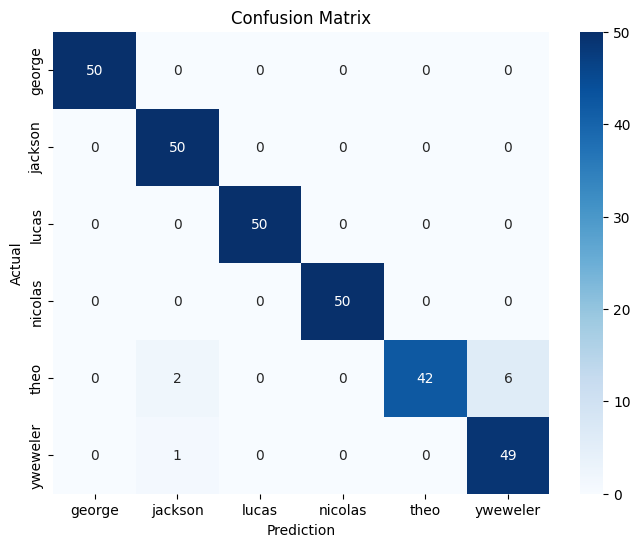

In [39]:
show_speakerEvaluation(speakerDetection_models, mode="library", test_directory="/home/alireza/University/AI/assignments/A2/autoTests")

<h3 style=color:#FF0013> <strong>Using HMM class written from Scratch</strong> </h3>

In [117]:
#Preprocessing

source_dir = "./recordings"
destination_dir = "./datasetBySpeaker"

for audio in os.listdir(source_dir):
    file_name = audio.split("_")
    if(not os.path.exists(os.path.join(destination_dir, file_name[1]))):
        os.makedirs(os.path.join(destination_dir, file_name[1]))
    
    remove_silence_and_save(os.path.join(source_dir, audio), os.path.join(destination_dir, file_name[1], audio))
    #shutil.copy(os.path.join(source_dir, audio), os.path.join(destination_dir, file_name[1]))

print("Segmentation and Preprocessing Complete!")

Segmentation and Preprocessing Complete!


In [41]:
import python_speech_features
import numpy as np

speakers = ["george", "jackson", "lucas", "nicolas", "theo", "yweweler"]

# Define number of hidden states for each number HMM 
n_states = 13
audioLength = 1200

# Create dictionary to store number HMMs
custom_speakerDetection_models = {}

for name in speakers:  

  # Initialize a GaussianHMM instance
  custom_speakerDetection_models[name] = HMM(num_hidden_states=n_states)


# Training data (Extracting features)
speaker_features = {}  # MFCC features for each speaker

for name in speakers:
    X = np.array([])
    files = os.listdir(os.path.join(destination_dir, name))
    tracks = [file for file in files]
    for track in tracks :
      signal, sampleRate = librosa.load(os.path.join(destination_dir, name, track))
      mfccs = python_speech_features.mfcc(signal, sampleRate, nfft=1024)[:audioLength,:]
      if(len(X) == 0):
        X = mfccs
      else :
        X = np.append(X, mfccs, axis=0)
    speaker_features[name] = X
        
      


# Train each HMM using features of corresponding number data
for name, features in speaker_features.items():
     custom_speakerDetection_models[name].train(features.T/np.amax(features.T), 20)
  
print("Model Training Complete!")

Model Training Complete!


╒══════════╤═══════════╤═════════╤═══════════╕
│ george   │   jackson │   lucas │   nicolas │
╞══════════╪═══════════╪═════════╪═══════════╡
│ george   │  0.704225 │    1    │  0.826446 │
├──────────┼───────────┼─────────┼───────────┤
│ jackson  │  0.961538 │    0.5  │  0.657895 │
├──────────┼───────────┼─────────┼───────────┤
│ lucas    │  0.923077 │    0.72 │  0.808989 │
├──────────┼───────────┼─────────┼───────────┤
│ nicolas  │  0.806452 │    1    │  0.892857 │
├──────────┼───────────┼─────────┼───────────┤
│ theo     │  0.860465 │    0.74 │  0.795699 │
├──────────┼───────────┼─────────┼───────────┤
│ yweweler │  0.627119 │    0.74 │  0.678899 │
╘══════════╧═══════════╧═════════╧═══════════╛
Total Accuracy: 78.333%


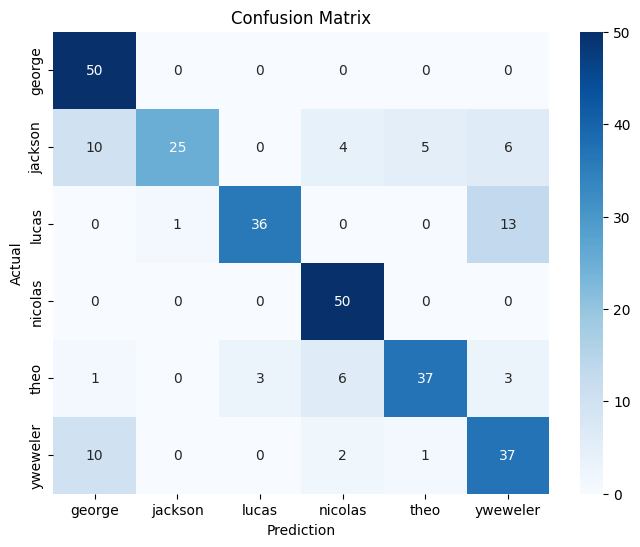

In [42]:
show_speakerEvaluation(custom_speakerDetection_models, mode="non-library", test_directory="/home/alireza/University/AI/assignments/A2/autoTests")

### ```Library vs. CustomHMM```
- __Key Points__ :
    - Library implementation had overal better performance (as expected)
    - In contradiction to when the target variable was digit, in this section __both__ Library and custom implementation had better performance when the __silent parts__ were __removed__ in preprocessing section (eventhough Library's uplift was small)
    - Library had more problems (relatively) in Precision but Custom HMM had more problems (relatively) in Recall
    - __Both__ had trouble in detecting __Theo__'s voice! (might point to the fact that Theo's audio files had lower quality)

<img src="./Questions/Q16.png"/>

#### There are number of reasons why detecting someone's voice identity is easier than understanding their speech.
 __Speaker Identification__ Analyzes a Smaller Set of Features :
- __Speaker recognition__ needs to analyze someone's voice characteristics unique to them
    - Pitch
    - Timbre
    - Vocal tract characteristics
- __Speech recognition__ needs to decipher much more information
    - Individual words and their pronunciations (including accents)
    - Background Noise (could get handled in preprocessing)
